## Fear Prediction with Audio Visual features

In [1]:
import numpy as np
import pylab as pl
import re, fileinput
import os.path
import glob

import pandas as pd
from pandas import DataFrame, Series

import matplotlib.pyplot as plt
import matplotlib.colors as colors


import matplotlib
matplotlib.style.use('ggplot')

%matplotlib inline

In [2]:
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn import svm
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
import scipy
from scipy.stats import pearsonr

In [3]:

med2017home = '/home/deepuser/yasemin/'
# Input data
movieNames = ['After_The_Rain','Attitude_Matters','Barely_legal_stories','Between_Viewings','Big_Buck_Bunny','Chatter','Cloudland','Damaged_Kung_Fu','Decay','Elephant_s_Dream','First_Bite','Full_Service','Islands','Lesson_Learned','Norm','Nuclear_Family','On_time','Origami','Parafundit','Payload','Riding_The_Rails','Sintel','Spaceman','Superhero','Tears_of_Steel','The_room_of_franz_kafka','The_secret_number','To_Claire_From_Sonny','Wanted','You_Again']

pathcontinuous = med2017home
continuousAnnotationsFolder = pathcontinuous +'continuous-annotations/'
devdatacontinous =  pathcontinuous + "continuous-movies/"
#pathcontfeatures = "/home/yt/Desktop/cvpr2014/repro/mediaeval/data/dataset/Continuous/features-out-1/"

med2017visualFeaturesfolder= med2017home + 'MEDIAEVAL17-DevSet-Visual_features/features/'
med2017audiofolder= med2017home + 'MEDIAEVAL17-DevSet-Audio_features/features/'
med2017annotationsFolder = med2017home + 'MEDIAEVAL17-DevSet-Valence_Arousal-annotations/annotations/'
med2017fearFolder = med2017home + 'MEDIAEVAL17-DevSet-Fear-annotations/annotations/'


In [4]:
med2017visualFeaturesfolderTest= med2017home + 'MEDIAEVAL17-TestSet-Visual_features/visual_features/'
med2017audiofolderTest = med2017home + 'MEDIAEVAL17-TestSet-Audio_features/audio_features/'
med2017datafolderTest = med2017home + 'MEDIAEVAL17-TestSet-Data/data/'


In [5]:
files = glob.glob(med2017datafolderTest+'*')
testmovienames =[ f.split('/')[-1].replace('.mp4','') for f in sorted(files) ]

In [6]:
files = glob.glob(devdatacontinous+'*')
devmovienames =[ f.split('/')[-1].replace('.mp4','') for f in sorted(files) ]

In [7]:
med2017datafolderTest

'/home/deepuser/yasemin/MEDIAEVAL17-TestSet-Data/data/'

In [8]:
len(testmovienames)

0

In [9]:
len(devmovienames)

0

In [10]:
groups = {
    0:['You_Again','Damaged_Kung_Fu','The_secret_number','Spaceman'],
    1:['Cloudland','Origami','Riding_The_Rails','Tears_of_Steel','Sintel'],
    2:['On_time','Elephant_s_Dream','Norm','Big_Buck_Bunny','Chatter','Full_Service'],
    3:['Islands','To_Claire_From_Sonny','Nuclear_Family','After_The_Rain','Parafundit'],
    4:['Decay'],
    5:['The_room_of_franz_kafka','Attitude_Matters','Lesson_Learned','Superhero'],
    6:['First_Bite','Wanted','Between_Viewings','Barely_legal_stories','Payload']
}

In [11]:
def gettraintestmovielist(groupno):
    testlist = groups[groupno]
    trainlist =[]
    for idx, group in enumerate(groups):
        if idx != groupno:
            for g in groups[idx]:
                trainlist.append(g)
    return trainlist, testlist



In [12]:
trainlist, testlist=gettraintestmovielist(1)  # index 1 olanları test , diğerlerini train yapan fonksiyon

## Fear Annotations

In [13]:
def getFearDf(movname):
    filename = os.path.join(med2017fearFolder, movname + '-MEDIAEVAL2017-fear.txt')
    annotation = np.genfromtxt(filename, names=True, delimiter='\t', dtype=None)
    df = pd.DataFrame(annotation)
    return df


## Audio Features

In [14]:
def getAudioDf(moviename,folder=med2017audiofolder):
    if 'TestSet' in folder:
        files = glob.glob(folder+moviename+'/audio_features/*.csv')
    else:
        files = glob.glob(folder+moviename+'/*.csv')
    files = sorted(files)
    files
    alist = []
    for fname in files:
        f=open(fname,'r')
        h = []
        for l in f :
            if '@attribute' in l:
                h.append(l.split()[1])
            elif l == '\n':
                l
            elif l[0] =='@':
                l
            else:
                alist.append(map(float,l.split(',')[1:])) #first attribute is string ,skipped
        f.close()
    
    return pd.DataFrame(alist,columns=h[1:])

In [15]:
def getMovieListAudioFearDf(movieNames,folder=med2017audiofolder):
    Xa = getAudioDf(movieNames[0],folder)
    y = getFearDf(movieNames[0]).Fear
    
    mlen = min(len(Xa),len(y))
    Xa = Xa[:mlen]
    y = y[:mlen]
    
    for mov in movieNames[1:]:
        tXa = getAudioDf(mov)
        ty = getFearDf(mov).Fear
        
        mlen = min(len(tXa),len(ty))
        tXa = tXa[:mlen]
        ty = ty[:mlen]
    
        Xa  = Xa.append(tXa)
        y  = y.append(ty)
        
    return Xa,y

In [16]:
#movielisttrain, movielisttest=gettraintestmovielist(1)
#Xtrain, ytrain = getMovieListAudioFearDf(movielisttrain)
#Xtest, ytest = getMovieListAudioFearDf(movielisttest)
#Xtrain.shape, Xtest.shape, ytrain.shape,ytest.shape

In [ ]:
getAudioDf('MEDIAEVAL17_00',folder=med2017audiofolderTest).tail()

In [ ]:
getAudioDf(movieNames[0]).tail()

In [20]:
getFearDf(movieNames[0]).tail()

,Id,Time,Fear
112,112,560,0
113,113,565,0
114,114,570,0
115,115,575,0
116,116,580,0


## Visual Features

In [19]:
visual_feat = ['acc', 'cedd', 'cl', 'eh', 'fc6', 'fcth', 
               'gabor', 'jcd', 'lbp', 'sc', 'tamura'   ]

In [20]:
def getVisFeatureDf(moviename,typename):
    files = glob.glob(med2017visualFeaturesfolder+moviename+'/'+typename+'/*.txt')
    files = sorted(files)
    alist = []
    for fname in files:
        f=open(fname,'r')
        for l in f:
            alist.append(map(float,l.split(',')))
        f.close()
    return pd.DataFrame(alist)

def getAvgVisFeatureDf(moviename,typename):
    df = getVisFeatureDf(moviename,typename)
    dfwindow = df.rolling(10).mean()[10::5]
    dfwindow.reset_index(inplace=True)
    dfwindow.drop('index',axis=1,inplace=True)
    return dfwindow

def getAvgVisFeatListDf(moviename,featlist):
    df = getVisFeatureDf(moviename,featlist[0])
    for feat in featlist[1:]:
        tdf = getVisFeatureDf(moviename,feat)
        df = pd.concat([df,tdf],axis=1)
    
    dfwindow = df.rolling(10).mean()[10::5]
    dfwindow.reset_index(inplace=True)
    dfwindow.drop('index',axis=1,inplace=True)
    dfwindow.columns=list(range(len(dfwindow.columns)))
    return dfwindow

In [21]:
def getMovListVisFearDf(movieNames,featname):
    X = getAvgVisFeatureDf(movieNames[0],featname)
    y = getFearDf(movieNames[0]).Fear[:len(X)]

    for mov in movieNames[1:]:
        tX = getAvgVisFeatureDf(mov,featname)
        ty = getFearDf(mov).Fear[:len(tX)]
        X  = X.append(tX)
        y  = y.append(ty)
        
    return X,y

In [22]:
getVisFeatureDf(movieNames[1],'cl').tail(10)

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
1364,2.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,...,16.0,16.0,16.0,16.0,32.0,16.0,16.0,16.0,16.0,16.0
1365,2.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,...,16.0,16.0,16.0,16.0,32.0,16.0,16.0,16.0,16.0,16.0
1366,2.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,...,16.0,16.0,16.0,16.0,32.0,16.0,16.0,16.0,16.0,16.0
1367,2.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,...,16.0,16.0,16.0,16.0,32.0,16.0,16.0,16.0,16.0,16.0
1368,2.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,...,16.0,16.0,16.0,16.0,32.0,16.0,16.0,16.0,16.0,16.0
1369,2.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,...,16.0,16.0,16.0,16.0,32.0,16.0,16.0,16.0,16.0,16.0
1370,2.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,...,16.0,16.0,16.0,16.0,32.0,16.0,16.0,16.0,16.0,16.0
1371,2.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,...,16.0,16.0,16.0,16.0,32.0,16.0,16.0,16.0,16.0,16.0
1372,2.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,...,16.0,16.0,16.0,16.0,32.0,16.0,16.0,16.0,16.0,16.0
1373,2.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,...,16.0,16.0,16.0,16.0,32.0,16.0,16.0,16.0,16.0,16.0


In [25]:
#getAvgVisFeatureDf(movieNames[0],'cl').tail()

In [26]:
#getAvgVisFeatListDf(movieNames[0],['cl']).tail()

In [27]:
#getMovListVisFearDf(movieNames[:2],'cl')

In [23]:
def getMovListVisFusionFearDf(movieNames,featlist):
    X,y = getMovListVisFearDf(movieNames,featlist[0])
    # y is the target value and it is equal for all feature type 
    for feattype in featlist[1:] :
        tX, y = getMovListVisFearDf(movieNames,feattype)
        X = pd.concat( [X,tX], axis=1 )
    return X,y

In [24]:
#xX,ty = getMovListVisFusionFearDf(movieNames[:2],['cl','gabor'])
#xX.shape,ty.shape

In [25]:
def getMovListAudioVisFearFeatListDf(movieNames,featlist):
    Xv = getAvgVisFeatureDf(movieNames[0],featlist[0])
    Xa = getAudioDf(movieNames[0])
    y = getFearDf(movieNames[0]).Fear
    
    mlen = min(len(Xv),len(Xa),len(y))
    
    Xv = Xv[:mlen]
    Xa = Xa[:mlen]
    y = y[:mlen]
    
    for feattype in featlist[1:]:
        fXv = getAvgVisFeatureDf(movieNames[0],feattype)[:mlen]
        Xv = pd.concat( [Xv,fXv], axis=1 )

    for mov in movieNames[1:]:
        tXv = getAvgVisFeatureDf(mov,featlist[0])
        tXa = getAudioDf(mov)
        ty = getFearDf(mov).Fear
        
        mlen = min(len(tXv),len(tXa),len(ty))
        tXv = tXv[:mlen]
        tXa = tXa[:mlen]
        ty = ty[:mlen]
        
        for feattype in featlist[1:]:
            fXv = getAvgVisFeatureDf(mov,feattype)[:mlen]
            tXv = pd.concat( [tXv,fXv], axis=1 )

        Xv  = Xv.append(tXv)
        Xa  = Xa.append(tXa)
        y  = y.append(ty)
        
    return Xv,Xa,y

In [26]:
#tXv,tXa,ty = getMovListAudioVisFearFeatListDf(movieNames[:2],['cl','gabor'])
#tXv.shape,tXa.shape,ty.shape

In [27]:
%%time
featlist = ['gabor', 'jcd', 'lbp', 'sc', 'tamura' ]

movielisttrain, movielisttest=gettraintestmovielist(0)

Xtrainv,Xtraina, ytrain = getMovListAudioVisFearFeatListDf(movielisttrain,featlist)
Xtestv,Xtesta, ytest = getMovListAudioVisFearFeatListDf(movielisttest,featlist)

print(Xtrainv.shape,Xtraina.shape , ytrain.shape)
print(Xtestv.shape,Xtesta.shape, ytest.shape)

(4521, 566) (4521, 1583) (4521,)
(743, 566) (743, 1583) (743,)
CPU times: user 35.4 s, sys: 1.2 s, total: 36.6 s
Wall time: 36.6 s


## Low level cinematographic Features

In [28]:
def getLowFeatureDf(movname):
    fname = movname +'.mp4continous_features.txt'
    print(fname)
    df = pd.DataFrame(np.genfromtxt( os.path.join(pathcontfeatures,fname)))
    df.columns = ['time','framemean','huemean','satmean','valmean', 'redmean','greenmean','bluemean', 'lummean','motion']
    return df


def getLowFeatureSecDf(movname):
    pdf = getLowFeatureDf(movname)
    dfwindow = pdf[ pdf.time % 23 == 1]
    #dfwindow = pdf.rolling(3).mean()[3::1]
    dfwindow.reset_index(inplace=True)
    #dfwindow.columns = ['time','framemean','huemean','satmean','valmean', 'redmean','greenmean','bluemean', 'lummean','motion']
    #return dfwindow[['framemean','huemean','satmean','valmean', 'redmean','greenmean','bluemean', 'lummean','motion']]
    return dfwindow

def getLowFeature10SecDf(movname):
    pdf = getLowFeatureDf(movname)
    dfwindow = pdf[ pdf.time % 23 == 1]
    dfwindow.reset_index(inplace=True)
    #dfwindow.drop('index',axis=1,inplace=True)
    #dfwindow = dfwindow.rolling(10).mean()[10::5]
    dfwindow.reset_index(inplace=True)
    
    #dfwindow[['framemean','huemean','satmean','valmean', 'redmean','greenmean','bluemean', 'lummean','motion']]
    return dfwindow

In [29]:
def getMovieListLowFeatFearDf(movieNames):
    X = getLowFeature10SecDf(movieNames[0])
    y = getFearDf(movieNames[0]).Fear[:len(X)]

    for mov in movieNames[1:]:
        tX=getLowFeatureDf(mov)
        ty=getFearDf(mov).Fear[:len(tX)]
        X = X.append(tX)
        y = y.append(ty)
        if (X.shape != y.shape):
            print(mov, X.shape, y.shape)
    return X,y

In [30]:
#getLowFeatureDf(movieNames[1]).tail()

In [ ]:
getLowFeatureSecDf(movieNames[1]).tail()

In [ ]:
getLowFeature10SecDf(movieNames[1]).tail(15)

In [ ]:
tX,ty = getMovieListLowFeatFearDf(movieNames)

## Grid-Search cross validation Logistic Regression

logictic regression classifier has lower accuracy and precision especially for visual features.

In [66]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline



pipe = make_pipeline(LogisticRegression())
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}

grid_visual = GridSearchCV(pipe, param_grid, cv=5,n_jobs=-1)
grid_visual.fit(Xtrainv, ytrain)

grid_audio = GridSearchCV(pipe, param_grid, cv=5,n_jobs=-1)
grid_audio.fit(Xtraina, ytrain)


CPU times: user 15.7 s, sys: 852 ms, total: 16.6 s
Wall time: 1min 1s


In [67]:
print("Best cross-validation score: {:.2f}".format(grid_visual.best_score_))
print("Best parameters: ", grid_visual.best_params_)

print("Best cross-validation score: {:.2f}".format(grid_audio.best_score_))
print("Best parameters: ", grid_audio.best_params_)


Best cross-validation score: 0.96
Best parameters:  {'logisticregression__C': 0.001}
Best cross-validation score: 0.95
Best parameters:  {'logisticregression__C': 0.001}


In [68]:
predictionsv = LogisticRegression(C=0.001).fit(Xtrainv, ytrain).predict(Xtestv)
predictionsa = LogisticRegression(C=0.001).fit(Xtraina, ytrain).predict(Xtesta)

print('Logistic Regression:\n {}\n'.format(metrics.classification_report(predictionsv,ytest)))
print('Logistic Regression:\n {}\n'.format(metrics.classification_report(predictionsa,ytest))) 

Logistic Regression:
              precision    recall  f1-score   support

          0       1.00      0.87      0.93       912
          1       0.00      0.00      0.00         0

avg / total       1.00      0.87      0.93       912


Logistic Regression:
              precision    recall  f1-score   support

          0       1.00      0.87      0.93       909
          1       0.01      0.33      0.02         3

avg / total       0.99      0.87      0.93       912




/home/deepuser/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [69]:
%%time
lgcv = LogisticRegression(C=0.001)
lgcv.fit(Xtrainv, ytrain)

lgca = LogisticRegression(C=0.001)
lgca.fit(Xtraina, ytrain)

print('Visual Logistic Regression:\n {}\n'.format(metrics.classification_report(ytest,lgcv.predict(Xtestv))))
print('Visual Logistic Regression AVP: {:.2f}'.format(metrics.average_precision_score(ytest,lgcv.predict(Xtestv) , average='macro')))
print('Visual Logistic Accuracy:       {:.2f}'.format(metrics.accuracy_score(ytest,lgcv.predict(Xtestv))))

print('Audio Logistic Regression:\n {}\n'.format(metrics.classification_report(ytest,lgca.predict(Xtesta)))) 
print('Audio Logistic Regression AVP: {:.2f}'.format(metrics.average_precision_score(ytest,lgca.predict(Xtesta) , average='macro')))
print('Audio Logistic Accuracy:       {:.2f}'.format(metrics.accuracy_score(ytest,lgca.predict(Xtesta))))

latefusionXtrain = np.transpose([lgcv.predict(Xtrainv),lgca.predict(Xtraina)])

fuslgc = LogisticRegression(C=0.001)
fuslgc.fit(latefusionXtrain,ytrain)

#Test
latefusionXtest = np.transpose([lgcv.predict(Xtestv),lgca.predict(Xtesta)])
pred_ytest = fuslgc.predict(latefusionXtest)

print('Fusion Logistic Regression:\n {}\n'.format(metrics.classification_report(pred_ytest,ytest)))



Visual Logistic Regression:
              precision    recall  f1-score   support

          0       0.87      1.00      0.93       793
          1       0.00      0.00      0.00       119

avg / total       0.76      0.87      0.81       912


Visual Logistic Regression AVP: 0.57
Visual Logistic Accuracy:       0.87
Audio Logistic Regression:
              precision    recall  f1-score   support

          0       0.87      1.00      0.93       793
          1       0.33      0.01      0.02       119

avg / total       0.80      0.87      0.81       912


Audio Logistic Regression AVP: 0.24
Audio Logistic Accuracy:       0.87
Fusion Logistic Regression:
              precision    recall  f1-score   support

          0       1.00      0.87      0.93       912
          1       0.00      0.00      0.00         0

avg / total       1.00      0.87      0.93       912


CPU times: user 12.6 s, sys: 36 ms, total: 12.6 s
Wall time: 8.84 s


/home/deepuser/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/deepuser/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## SVC Classifier
Parameters are found with grid search:


{'classifier': SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
   max_iter=-1, probability=False, random_state=None, shrinking=True,
   tol=0.001, verbose=False),
 'classifier__C': 0.001,
 'classifier__gamma': 0.001,
 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}



In [71]:
%%time
lgcv = SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
   max_iter=-1, probability=False, random_state=None, shrinking=True,
   tol=0.001, verbose=False)
lgcv.fit(Xtrainv, ytrain)

lgca = SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
   max_iter=-1, probability=False, random_state=None, shrinking=True,
   tol=0.001, verbose=False)
lgca.fit(Xtraina, ytrain)

print('Visual SVC :\n {}\n'.format(metrics.classification_report(ytest,lgcv.predict(Xtestv))))
print('Visual SVC AVP: {:.2f}'.format(metrics.average_precision_score(ytest,lgcv.predict(Xtestv) , average='macro')))
print('Visual SVC Accuracy:       {:.2f}'.format(metrics.accuracy_score(ytest,lgcv.predict(Xtestv))))

print('Audio SVC:\n {}\n'.format(metrics.classification_report(ytest,lgca.predict(Xtesta)))) 
print('Audio SVC AVP: {:.2f}'.format(metrics.average_precision_score(ytest,lgca.predict(Xtesta) , average='macro')))
print('Audio SVC Accuracy:       {:.2f}'.format(metrics.accuracy_score(ytest,lgca.predict(Xtesta))))

latefusionXtrain = np.transpose([lgcv.predict(Xtrainv),lgca.predict(Xtraina)])

fuslgc = LogisticRegression(C=0.01)
fuslgc.fit(latefusionXtrain,ytrain)

#Test
latefusionXtest = np.transpose([lgcv.predict(Xtestv),lgca.predict(Xtesta)])
pred_ytest = fuslgc.predict(latefusionXtest)

print('Fusion Logistic Regression:\n {}\n'.format(metrics.classification_report(pred_ytest,ytest)))



/home/deepuser/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Visual SVC :
              precision    recall  f1-score   support

          0       0.87      1.00      0.93       793
          1       0.00      0.00      0.00       119

avg / total       0.76      0.87      0.81       912


Visual SVC AVP: 0.57
Visual SVC Accuracy:       0.87
Audio SVC:
              precision    recall  f1-score   support

          0       0.87      1.00      0.93       793
          1       0.00      0.00      0.00       119

avg / total       0.76      0.87      0.81       912


Audio SVC AVP: 0.57
Audio SVC Accuracy:       0.87
Fusion Logistic Regression:
              precision    recall  f1-score   support

          0       1.00      0.87      0.93       912
          1       0.00      0.00      0.00         0

avg / total       1.00      0.87      0.93       912


CPU times: user 17.9 s, sys: 0 ns, total: 17.9 s
Wall time: 17.9 s


/home/deepuser/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [72]:
## Models are stored
from sklearn.externals import joblib
joblib.dump(lgcv, 'models/fear-visual-svm.pkl')
joblib.dump(lgca, 'models/fear-audio-svm.pkl')
joblib.dump(fuslgc, 'models/fear-fusion-logisticreg.pkl')


['models/fear-fusion-logisticreg.pkl']

In [73]:
# Load Models
visusvm = joblib.load('models/fear-visual-svm.pkl')
audisvm = joblib.load('models/fear-audio-svm.pkl')
fusesvm = joblib.load('models/fear-fusion-logisticreg.pkl')


In [ ]:
#RUN-1


## Gradient Boosting Classifier

Boosting is a sequential technique which works on the principle of ensemble. It combines a set of weak learners and delivers improved prediction accuracy. At any instant t, the model outcomes are weighed based on the outcomes of previous instant t-1. The outcomes predicted correctly are given a lower weight and the ones miss-classified are weighted higher. 

In [74]:
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn import cross_validation
from sklearn import metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

/home/deepuser/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/deepuser/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [79]:
def modelfit(alg, X, y, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(X, y)
        
    #Predict training set:
    dtrain_predictions = alg.predict(X)
    dtrain_predprob = alg.predict_proba(X)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, X, y, cv=cv_folds, scoring='roc_auc',n_jobs=-1)
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(y.values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(y, dtrain_predprob))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, X.columns).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.9818
AUC Score (Train): 0.994834
CV Score : Mean - 0.519357 | Std - 0.1122577 | Min - 0.3433766 | Max - 0.6797389


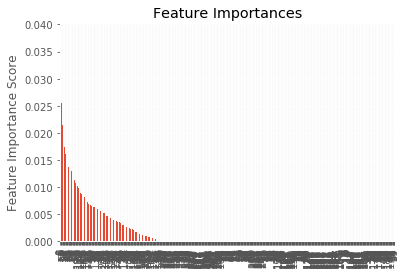

In [80]:
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, Xtrainv, ytrain)


Model Report
Accuracy : 0.9881
AUC Score (Train): 0.999502
CV Score : Mean - 0.6656424 | Std - 0.04866573 | Min - 0.6116904 | Max - 0.7511752


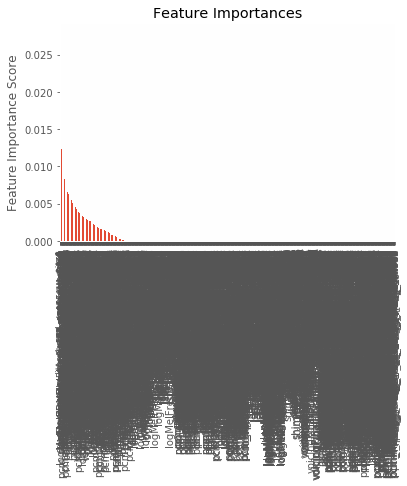

In [81]:
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, Xtraina, ytrain)

In [82]:
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")
    return img


In [84]:
param_test1 = {'n_estimators':list(range(20,81,10))}
gsearch1 = GridSearchCV(
    estimator = GradientBoostingClassifier(
        learning_rate=0.05,  
        min_samples_split=500,
        min_samples_leaf=50,
        max_depth=8,
        max_features='sqrt',subsample=0.8,random_state=10), 
    param_grid = param_test1, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch1.fit(Xtrainv,ytrain)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_


([mean: 0.49391, std: 0.06798, params: {'n_estimators': 20},
  mean: 0.51926, std: 0.08800, params: {'n_estimators': 30},
  mean: 0.53238, std: 0.08495, params: {'n_estimators': 40},
  mean: 0.53660, std: 0.08631, params: {'n_estimators': 50},
  mean: 0.53048, std: 0.09453, params: {'n_estimators': 60},
  mean: 0.53148, std: 0.09802, params: {'n_estimators': 70},
  mean: 0.54262, std: 0.09259, params: {'n_estimators': 80}],
 {'n_estimators': 80},
 0.5426181559653471)

In [85]:

gsearch1.fit(Xtraina,ytrain)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.67733, std: 0.08642, params: {'n_estimators': 20},
  mean: 0.68530, std: 0.09128, params: {'n_estimators': 30},
  mean: 0.67554, std: 0.08983, params: {'n_estimators': 40},
  mean: 0.67628, std: 0.08732, params: {'n_estimators': 50},
  mean: 0.67153, std: 0.08374, params: {'n_estimators': 60},
  mean: 0.66925, std: 0.08073, params: {'n_estimators': 70},
  mean: 0.67658, std: 0.08340, params: {'n_estimators': 80}],
 {'n_estimators': 30},
 0.6853008630111692)

In [88]:
param_test2 = {'max_depth':list(range(5,16,2)), 'min_samples_split':list(range(200,1001,200))}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch2.fit(Xtraina,ytrain)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.65856, std: 0.07867, params: {'max_depth': 5, 'min_samples_split': 200},
  mean: 0.67126, std: 0.09543, params: {'max_depth': 5, 'min_samples_split': 400},
  mean: 0.67575, std: 0.08657, params: {'max_depth': 5, 'min_samples_split': 600},
  mean: 0.68706, std: 0.10208, params: {'max_depth': 5, 'min_samples_split': 800},
  mean: 0.68417, std: 0.09009, params: {'max_depth': 5, 'min_samples_split': 1000},
  mean: 0.66692, std: 0.08614, params: {'max_depth': 7, 'min_samples_split': 200},
  mean: 0.66522, std: 0.07414, params: {'max_depth': 7, 'min_samples_split': 400},
  mean: 0.67908, std: 0.07967, params: {'max_depth': 7, 'min_samples_split': 600},
  mean: 0.68920, std: 0.08261, params: {'max_depth': 7, 'min_samples_split': 800},
  mean: 0.68779, std: 0.06802, params: {'max_depth': 7, 'min_samples_split': 1000},
  mean: 0.67400, std: 0.07357, params: {'max_depth': 9, 'min_samples_split': 200},
  mean: 0.69058, std: 0.08931, params: {'max_depth': 9, 'min_samples_split': 400},
  

In [89]:
param_test3 = {'min_samples_split':list(range(1000,2100,200)), 'min_samples_leaf':list(range(30,71,10))}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.05, n_estimators=60,max_depth=9,max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch3.fit(Xtraina,ytrain)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.69246, std: 0.07509, params: {'min_samples_leaf': 30, 'min_samples_split': 1000},
  mean: 0.69361, std: 0.07556, params: {'min_samples_leaf': 30, 'min_samples_split': 1200},
  mean: 0.69994, std: 0.07476, params: {'min_samples_leaf': 30, 'min_samples_split': 1400},
  mean: 0.71255, std: 0.07542, params: {'min_samples_leaf': 30, 'min_samples_split': 1600},
  mean: 0.71428, std: 0.07999, params: {'min_samples_leaf': 30, 'min_samples_split': 1800},
  mean: 0.71123, std: 0.08337, params: {'min_samples_leaf': 30, 'min_samples_split': 2000},
  mean: 0.68671, std: 0.07592, params: {'min_samples_leaf': 40, 'min_samples_split': 1000},
  mean: 0.68655, std: 0.07073, params: {'min_samples_leaf': 40, 'min_samples_split': 1200},
  mean: 0.69469, std: 0.07493, params: {'min_samples_leaf': 40, 'min_samples_split': 1400},
  mean: 0.70010, std: 0.07755, params: {'min_samples_leaf': 40, 'min_samples_split': 1600},
  mean: 0.70374, std: 0.08813, params: {'min_samples_leaf': 40, 'min_samples_spl

In [91]:
gsearch3.cv_results_['mean_test_score']

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [ ]:
gsearch3.cv_results_['mean_test_score'].reshape(6,-1)

In [ ]:
heatmap(gsearch3.cv_results_['mean_test_score'].reshape(6, -1),
                      xlabel="min_samples_split", ylabel="min_samples_leaf",
                      xticklabels=param_test3['min_samples_split'],
                      yticklabels=param_test3['min_samples_leaf'])

In [ ]:
param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler(), None],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [RandomForestClassifier(n_estimators=100)],


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler()],
     'classifier__gamma': [0.001, 1, 10],
     'classifier__C': [0.001, 1, 10]},
    {'classifier': [RandomForestClassifier(n_estimators=100)],
     'preprocessing': [None], 'classifier__max_features': [3]}]

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(Xtraina,ytrain)

print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
grid.grid_scores_, grid.best_params_, grid.best_score_

In [ ]:
grid.cv_results_['mean_test_score']

In [ ]:
 grid.best_params_